In [1]:
'''
Author: Oscar Javier Hernandez

QAOA problem solution using qiskit
'''

'\nAuthor: Oscar Javier Hernandez\n\nQAOA problem solution using qiskit\n'

In [2]:
import qiskit
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Problem: Maxcut using QAOA

Given a graph $G=(V,E)$ we label the vertices $x_i \in \lbrace -1,1\rbrace $ and define the cost function

\begin{align}
C(x) &= \frac{1}{2}\sum_{(i,j) \in E} w_{i,j}(1-x_i x_j).
\end{align}

The max-cut of $G$ is defined as the set of labels $x_i$ that maximize $C(x)$.

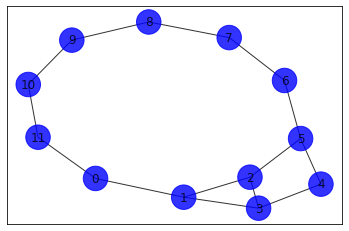

In [3]:
# Let us initialize a random graph G, with random connections
n_random = 3


# The total number of Nodes
n=12
G=nx.Graph()
G.add_nodes_from(range(0,n))

elist =[]
for k in range(0,n):
    n1,n2,w12 = (k,(k+1)%n,1.0)
    
    if(n1!=n2):
        elist.append((n1,n2,1.0))
G.add_weighted_edges_from(elist)


# Add custom edges
for k in range(0,n_random):
    n1,n2 = np.random.randint(0,n),np.random.randint(0,n)
    if(n1!=n2):
        G.add_edge(n1,n2,weight=1.0)

colors = ['b' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

# Quantum Solution: QAOA


The cost function $C(x)$ that we determined earlier can be optimized using QAOA. First, we map the cost function to a Hamiltonian, denoted $H_c$, consisting of Pauli-$Z$ operators (assuming that we have the case that $w_{ij}=1$)

\begin{align}
H_c = \frac{1}{2}\sum_{(n,m) \in E} (1-Z_n \otimes Z_m).
\end{align}


The algorithm consists of two steps. First, we prepare the QAOA state 

\begin{align}
\left| \gamma \beta \right> &= \prod_{q=1}^p e^{-i \beta_q B} e^{-i \gamma_q H_c} \left(H \otimes \cdots \otimes H \right) \left( |0\rangle \otimes \cdots \otimes |0\rangle \right),
\end{align}
where we have the mixing operator $B$ defined as 
\begin{align}
B &= \sum_k X_k.
\end{align}


After this state is constructed, we compute the expectation value of this state on the Hamiltonian of interest,

\begin{align}
F(\gamma,\beta) = \langle \gamma \beta|H_c|\gamma \beta \rangle.
\end{align}

This function is optimized using traditional methods and the optimal parameters $\gamma^*,\beta^*$ are stored. With these parameters known, we then measure the state $|\gamma^* \beta^* \rangle$ in the computational basis.   





# Gate Implementation of Operators

In this section, I will outline the implementation of the operators used for the QAOA.


## Implementation of $e^{-\beta X}$

This operator is implemented trivially in Quiskit using the rotation matrices. In particular, we use

\begin{align}
e^{-i\beta X} = R_x(2\beta)
\end{align}


## Implementation of $e^{-i\gamma \frac{1}{2}(1-Z_n \otimes Z_m)}$

This operator is not natively implemented in Qiskit. Therefore we must implement it ourselves. First, we note that the matrix representation of the two-qubit $ZZ$ gate is 

\begin{align}
Z_n \otimes Z_m = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1 
\end{bmatrix}.
\end{align}

Our task in this section is to exponentiate this matrix. 

\begin{align}
e^{-i\gamma \frac{1}{2}(1-Z_n \otimes Z_m)} = e^{-i\gamma \frac{1}{2}} \cdot e^{i \frac{1}{2}\gamma Z_n \otimes Z_m}
\\
= e^{-i\gamma \frac{1}{2}}e^{i\gamma \frac{1}{2}} \cdot \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & e^{-i \gamma } & 0 & 0 \\
0 & 0 & e^{-i \gamma } & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}\\
= \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & e^{-i \gamma } & 0 & 0 \\
0 & 0 & e^{-i \gamma } & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\end{align}


Therefore we have that

\begin{align}
e^{-i\gamma \frac{1}{2}(1-Z_n \otimes Z_m)} =  \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & e^{-i \gamma } & 0 & 0 \\
0 & 0 & e^{-i \gamma } & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\end{align}


This operator can be implemented very simply as follows. First, we note that

\begin{align}
U_1(\lambda) \otimes U_1(\lambda) = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & e^{i\lambda } & 0 & 0 \\
0 & 0 & e^{i \lambda } & 0 \\
0 & 0 & 0 & e^{i 2\lambda }
\end{bmatrix}
\end{align}

and therefore, if we combine this with a controlled $U1$-gate we have

\begin{align}
CU_1(\alpha) \left( U_1(\lambda) \otimes U_1(\lambda) \right) = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & e^{i\lambda } & 0 & 0 \\
0 & 0 & e^{i \lambda } & 0 \\
0 & 0 & 0 & e^{i \left(2\lambda +\alpha\right) }.
\end{bmatrix}
\end{align}

Using these results, we have

\begin{align}
e^{-i\gamma \frac{1}{2}(1-Z_n \otimes Z_m)} = CU_1(2\gamma) \left( U_1(-\gamma) \otimes U_1(-\gamma) \right).
\end{align}



In [4]:
'''
Here we implement all of the necessary functions that will be required to carry out the QAOA solution
'''

def produce_QAOA_state(gammas,betas,p=1):
    '''
    This function generates the QAOA state |gamma, beta>
    for a given order, p.
    
    '''

    # Create a Quantum Circuit acting on the q register
    circuit = qiskit.QuantumCircuit(n, n)

    # Prepare the state |alpha,beta>

    # We apply Hadamard to all of the qubits
    circuit.h(range(0,n))
    circuit.barrier()

    ##======================================
    # Prepare the QAOA-Trial State
    for pk in range(p):
        
        
        for edge in G.edges():
            k,l = edge[0],edge[1]
            
            # U(gamma)
            # control bit to the target bit
            circuit.u1(gammas[pk], k)
            circuit.u1(gammas[pk], l)
            circuit.cu1(-2*gammas[pk], k, l)
            circuit.barrier()
        
        # U(beta)
        circuit.rx(2*betas[pk], range(n))
        circuit.barrier()
    #=========================================
    circuit.measure(range(n),range(n))
    
    return circuit

def linear_transform(x):
    '''
    This function is used to simplify some calculations.
    
    x: Bitstring consisting of  {0 or 1} values
    
    
    mapping: 2*x-1
    
    returns:
    x_prime: numpy array with entries that are -1 or 1
    '''
    
    N=len(x)
    x_prime = np.zeros(N)
    
    
    for k in range(N):
        x_prime[k] = 2*int(x[k])-1
    
    return x_prime


def compute_cost(x,G):
    '''
    The cost of a bitstring x using the max-cut 
    cost function
    
    C = sum_{i,j} 1/2*(1-xi*xj)
    
    where xi,xj are either -1 or 1
    
    G: Graph object
    x: bitstring consisting of characters that are either 0 or 1.
    '''
    x_prime = linear_transform(x)
    
    c=0.0
    
    for edge in G.edges():
        k,l = edge[0],edge[1]
        c+= 0.5*(1.0-x_prime[k]*x_prime[l])
    
    return c



def expectation_value(gammas,betas,G,p,N_shots=100):
    '''
    Compute the expectation value of the Cost-Hamiltonian 
    
    H_c = 1/2 sum (1-Z_n Z_m)
    
    
    on the QAOA basis state |gamma,beta>
    
    F(gammas,betas) = <gammas betas|H_c|gammas betas>
    
    
    '''
    ev=0.0
    
    # Produce the backend
    backend = qiskit.Aer.get_backend("qasm_simulator")
    
    circuit = produce_QAOA_state(gammas,betas,p)
    simulate = qiskit.execute(circuit, backend=backend, shots=N_shots)
    
    results = simulate.result()
    counts = results.get_counts()
    
    for x in counts:
        ev += compute_cost(x,G)*(counts[x]/N_shots)
    
    
    return ev

# Optimize the Expectation value $F=\langle \gamma \beta| H_c|\gamma \beta\rangle$

Below, we optimize the expectation value of the $H_c$ using the QAOA trial wavefunction.

In [5]:
from scipy.optimize import minimize



#=========================================================================================
# Important, this is the chosen order for the QAOA optimization
p = 2
N_shots = 10000 # Number of shots to compute the expectation value
#=========================================================================================


def function(z):
    '''
    The expectation value function for the scipy 
    optimizer to optimize
    '''
    
    N = len(z)
    gammas = z[0:int(N/2)]
    betas = z[ int(N/2):N]
    
    f=-expectation_value(gammas,betas,G,p=int(N/2),N_shots=1000)
    
    return f

# initialize the set of gammas and betas
gammas = 2.0*np.pi*np.random.uniform(0,1,p)
betas = np.pi*np.random.uniform(0,1,p)


# Minimize the Objective function using the Nelder-Mead algorithm
z0 = np.concatenate((gammas,betas))
res = minimize(function, z0, method='nelder-mead',
               options={'xatol': 1e-2, 'disp': False})

print('='*100)
print('QAOA order: ',p)
print('Solution: ', res.x)
print('='*100)

QAOA order:  2
Solution:  [5.04629817 1.98960045 1.71742758 2.80162546]


# Having found the optimal values of $\gamma$ and $\beta$, we use these values and compute the expectation of the wavefunction 

Maximum observed energy:  13.0


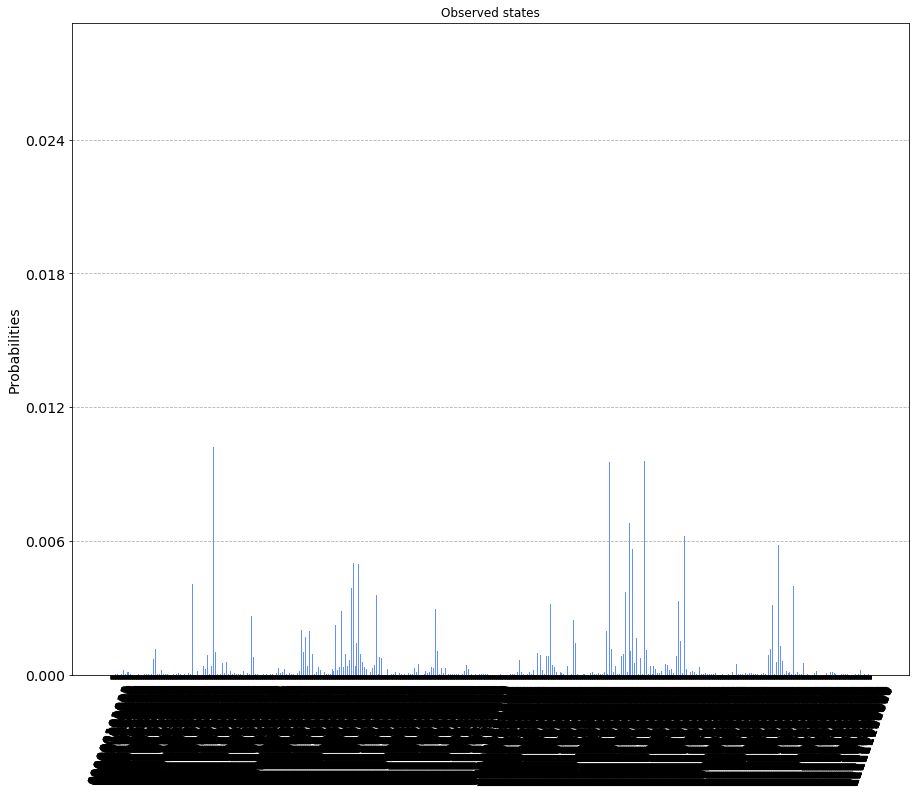

In [6]:
# The number of shots to sampe the QAOA wavefunction
N_shots  = 100000


# Extract the optimal parameters for the gamma and beta parameters
gammas_max = res.x[0:p] 
betas_max = res.x[p:2*p]

# retrieve the backend simulator
backend = qiskit.Aer.get_backend("qasm_simulator")

# Produce the QAOA states and sample the state in the computational basis
circuit = produce_QAOA_state(gammas_max,betas_max,p=p)
simulate = qiskit.execute(circuit, backend=backend, shots=N_shots)

# retrieve the results from the QAOA
QAOA_results = simulate.result()
counts = QAOA_results.get_counts()

# convert the observed bit-strings into 
x_observed = list(counts.keys())


#=============================================================
# Compute the observed energies and keep record of the best solutions
energy_distribution = []

for x in counts:
    energy_distribution.append(compute_cost(x,G))

# Get the maximum observed energy
max_energy = max(energy_distribution)

print('Maximum observed energy: ', max_energy)

max_energy_distributions = []

for k in range(len(counts)):
    Ek = energy_distribution[k]
    
    if(Ek==max_energy):
        max_energy_distributions.append(x_observed[k])

#=============================================================
    


# The bitstrings corresponding to the maximium amplitudes
plot_histogram(QAOA_results.get_counts(),
               title='Observed states',
              figsize=(15,12),
              bar_labels=False)


# Plot the Observed Energy Distribution From QAOA state

quantum algorithm:  ['010101010101', '101010101010']


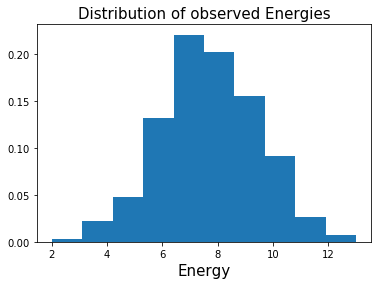

In [7]:
print('quantum algorithm: ', max_energy_distributions)

plt.title('Distribution of observed Energies',size=15)
plt.xlabel('Energy', size=15)
plt.hist(energy_distribution,density=True)
plt.show()

# Plot the solutions of the Maxcut problem

In the following cell, we make a plot of all of the solutions of the maxcut problem found by the QAOA sampler.

****************************************************************************************************
The following are the solutions to the maxcut problem
****************************************************************************************************


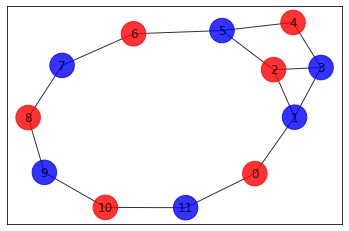

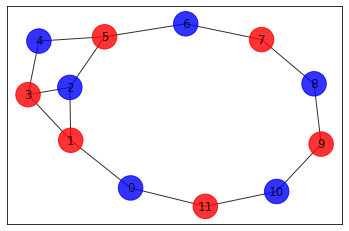

In [8]:
def return_colors(x):
    '''
    Function used to map the bit string to unique colors for
    visualization
    '''
    
    colors = []
    
    for k in range(len(x)):
        
        c = x[k]
        
        if(c=='1'):
            colors.append('b')
        elif(c=='0'):
            colors.append('r')
    
    return colors


print('*'*100)
print('The following are the solutions to the maxcut problem')
print('*'*100)

# Plot all of the solutions to the maxcut problem
for k in range(len(max_energy_distributions)):
    colors = return_colors(max_energy_distributions[k])
    pos = nx.spring_layout(G)
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    plt.show()

# We will Compute the Optimal Maxcut using brute force methods

In [9]:
import itertools

perms= ["".join(seq) for seq in itertools.product("01", repeat=n)]

scores = []

for xk in perms:
    Ek = compute_cost(xk,G)
    scores.append(Ek)

# Determine the maximum score
max_E = np.max(scores)

max_strings = []

# Find all energies where this is maximum and store the results
for k in range(len(scores)):
    
    score_k = scores[k]
    xk = perms[k]
    
    if(score_k==max_E):
        max_strings.append(xk)

print('='*100)
print('Maximum Energy: ', max_E,'\n')
print('Brute force solutions: {} \n'.format(len(max_strings)),max_strings,'\n')
print('QAOA solutions: {} \n'.format(len(max_energy_distributions)), max_energy_distributions)
print('='*100)


# Now we check that all of the solutions match, from the QAOA and from the brute force

count = 1
wrong_solutions =0
for s in max_energy_distributions:
    
    if(s in max_strings):
        count+=1
    else:
        wrong_solutions+=1


if(count-1 == len(max_strings)):
    print('*'*100)
    print('The QAOA solutions and the brute-force methods match. All optimal solutions found!')
    print('*'*100)
else:
    print('*'*100)
    print('The QAOA algorithm is missing {} solutions.'.format(len(max_strings)-count))
    print('The number of incorrect solutions is: {}'.format(wrong_solutions))
    print('*'*100)

Maximum Energy:  13.0 

Brute force solutions: 2 
 ['010101010101', '101010101010'] 

QAOA solutions: 2 
 ['010101010101', '101010101010']
****************************************************************************************************
The QAOA solutions and the brute-force methods match. All optimal solutions found!
****************************************************************************************************
